# Loan Default Predictions

Note that the data used will be fake, but for the purpose of demonstrating statistical analysis + machine learning, and intrepretation of results, I will treat this analysis as if I was working on a real dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
import graphviz
from pydotplus import graph_from_dot_data
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import warnings
from sklearn.linear_model import RidgeCV
import xgboost as xgb

In [2]:
loan_data = pd.read_csv('Loan_Data.csv')
print("Basic Information:")
print(loan_data.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Open Date               5000 non-null   object 
 1   Loan Amount             5000 non-null   float64
 2   Payment Amount          5000 non-null   float64
 3   Credit Score            5000 non-null   int64  
 4   Zip Code                5000 non-null   int64  
 5   Area Code               5000 non-null   int64  
 6   Gender                  5000 non-null   object 
 7   Age                     5000 non-null   int64  
 8   Income                  5000 non-null   float64
 9   Debt                    5000 non-null   float64
 10  Debt Payment Per Month  5000 non-null   float64
 11  Lending History         5000 non-null   int64  
 12  Interest Rate (%)       5000 non-null   float64
 13  Borrower_default        5000 non-null   int64  
dtypes: float64(6), int64(

In [3]:
# Convert the "Zip Code" and "Area Code" columns to char
loan_data["Zip Code"] = loan_data["Zip Code"].astype(str)
loan_data["Area Code"] = loan_data["Area Code"].astype(str)

# String to Date
loan_data['Open Date'] = pd.to_datetime(loan_data['Open Date'])

Rounding dollar columns to 2 decimal places and rate column to 3 decimal places 

In [4]:
dollar_columns = ["Loan Amount", "Payment Amount", "Income", "Debt", "Debt Payment Per Month"]

rate_columns = ["Interest Rate (%)"]

# Round dollar amount columns to 2 decimal points
loan_data[dollar_columns] = loan_data[dollar_columns].applymap(lambda x: round(x, 2))

# Round rate columns to 3 decimal places
loan_data[rate_columns] = loan_data[rate_columns].applymap(lambda x: round(x, 3))

Additional columns to be created, to explore the data beyond surface level.

In [5]:
loan_data[dollar_columns] = loan_data[dollar_columns].astype(float)

# Create and add the new "Debt_To_Income" column
loan_data["Debt_To_Income"] = loan_data["Debt"] / loan_data["Income"]


# Not required, but I'm adding this in case we want to use this for our analysis
loan_data['Term (Month)'] = (loan_data['Loan Amount'] / loan_data['Payment Amount']).round(2)

# Not required, but I'm adding this in case we want to use this for our analysis
loan_data['Payment Amount to Income'] = (loan_data['Payment Amount'] / loan_data['Income']).round(3)

# Not required, but I'm adding this in case we want to use this for our analysis
loan_data['Loan Amount to Income'] = (loan_data['Loan Amount'] / loan_data['Income']).round(3)

# Not required, but I'm adding this in case we want to use this for our analysis
loan_data['Expected Profit'] = (loan_data['Loan Amount'] -
                                (loan_data['Loan Amount'] / (1 + 0.01*(loan_data['Interest Rate (%)'] / 12)) ** loan_data['Term (Month)'])).round(2)

# Not required, but I'm adding this in case we want to use this for our analysis
loan_data['Expected Profit (Monthly)']  = loan_data['Expected Profit'] /12


# EDA 

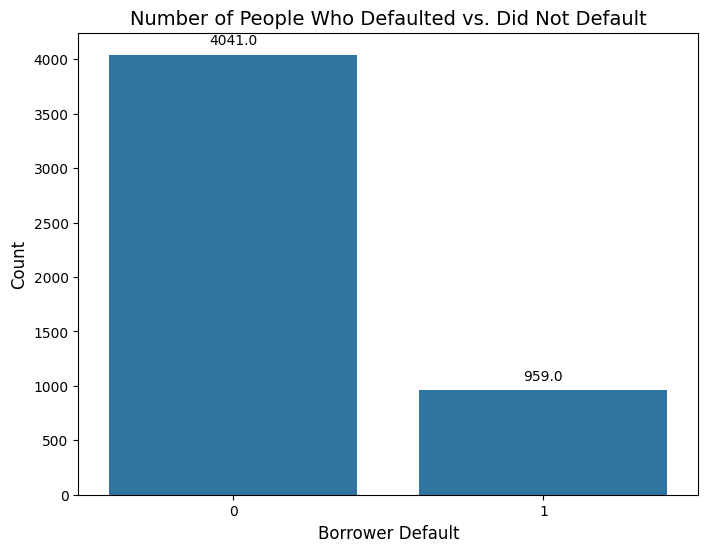

In [7]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Borrower_default', data=loan_data)

# Adding labels to the graph
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Borrower Default', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Number of People Who Defaulted vs. Did Not Default', fontsize=14)
plt.show()

#### Based on the above boxplot...
There are more borrowers who didn't default vs those who did. This could indicate that classifying the people who will actually default is harder than predicting people who won't default, due to the difference in volume of data.


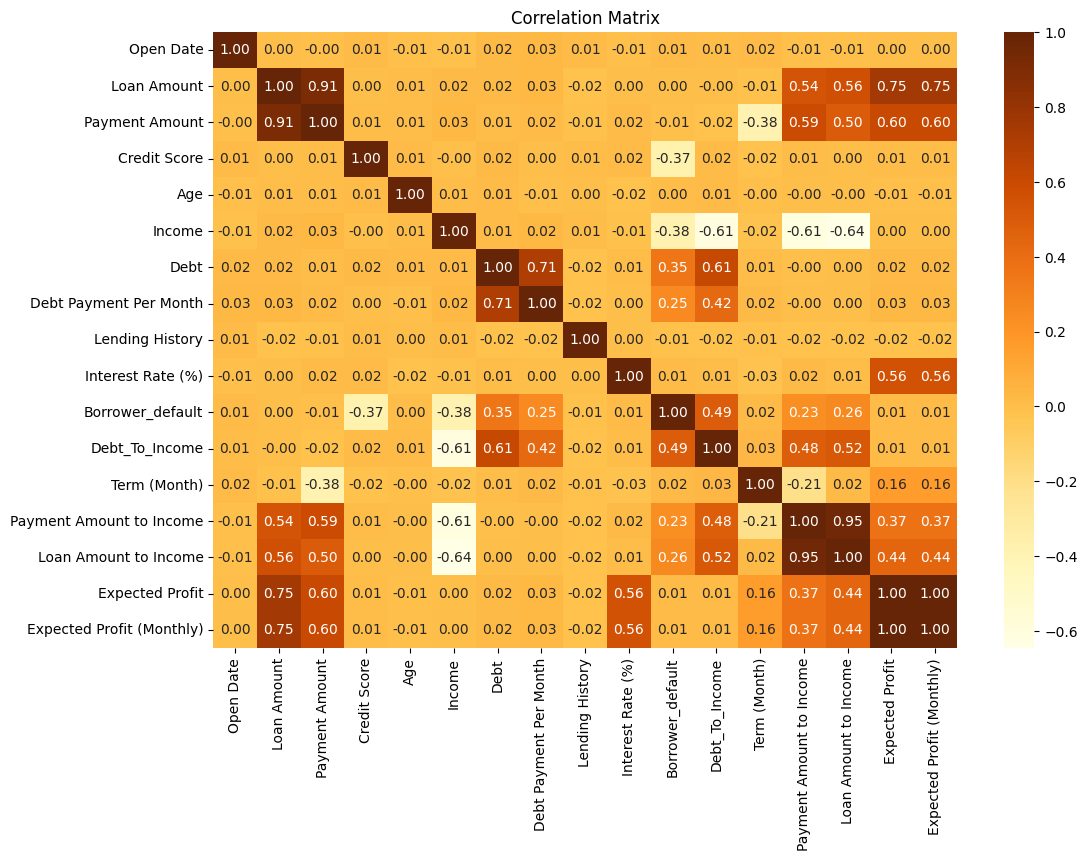

In [8]:
loan_data_condensed = loan_data.drop(columns=[ 'Gender', 'Zip Code', 'Area Code'])

corr_matrix = loan_data_condensed.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrBr', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Based on this correlation matrix above ...
We can see that Borrower Default has some noticable correlation with Income, Credit Score, Debt, Debt to Income, Debt Payment Per Month, Payment Amount to Income, and Loan Amount to Income. These are features that we should consider using in our model, but we can perform variable selection (such as forward and backward stepwise regression) to help us verify that. Also, it is important to note that some of the selected features will have strong collinearity with each other, so we would have to address this using something like PCA to reduce dimensionality. In this case, DTI will have strong correlation with Debt and Income, simply because DTI is derived from those two columns. You can argue the same for the rest of the columns that were created based on provided columns.

Additionally, the fact that there seems to be little correlation between Lending History and Credit Score is a bit surprising. I would assume that there is higher Credit Score if there is a lot of Lending History due to the borrower's ability to demonstrate trustability. Same with Credit Score and Interest Rate (%), most people would assume that a borrower's interest rate would be higher if his/her credit score is lower... The fact that date does not have a correlation with interest rate kinda tells me that the data is not too realistic.

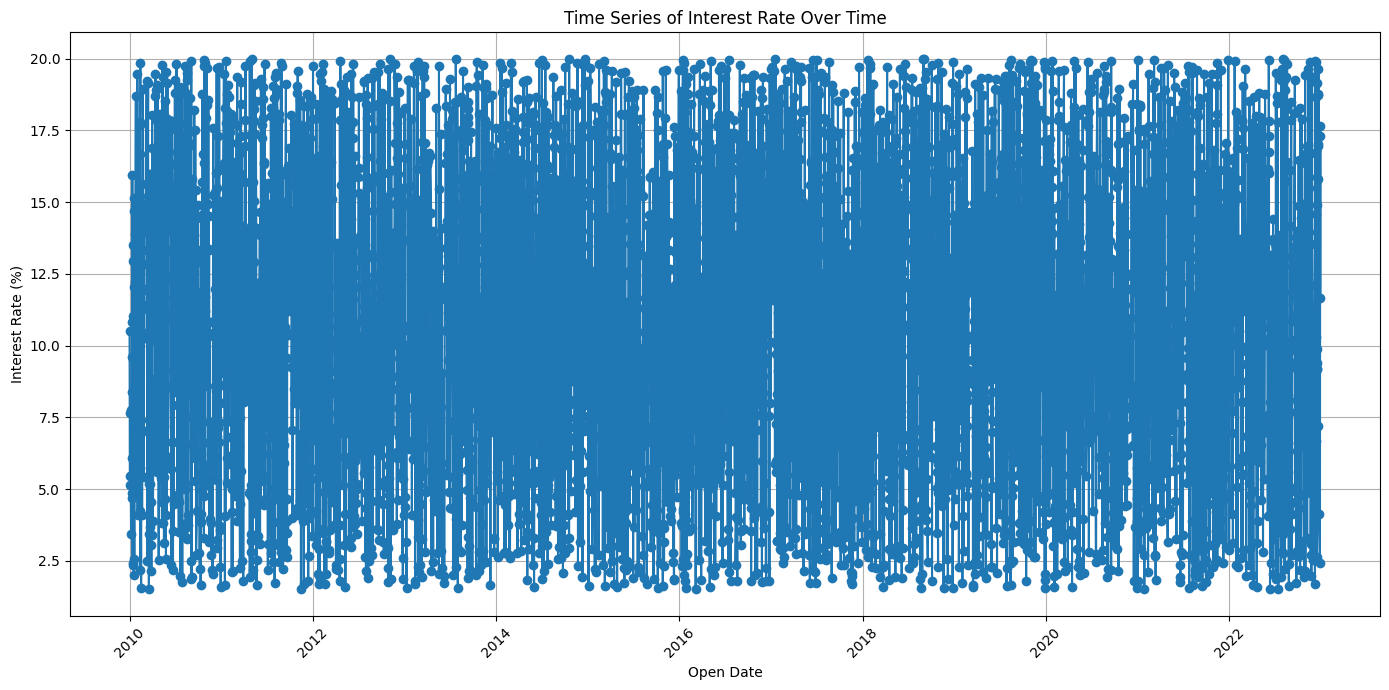

In [11]:
time_series_data = loan_data[['Open Date', 'Interest Rate (%)']]

# Sort by Open Date to ensure proper time series order
time_series_data = time_series_data.sort_values(by='Open Date')

plt.figure(figsize=(14, 7))
plt.plot(time_series_data['Open Date'], time_series_data['Interest Rate (%)'], marker='o', linestyle='-')
plt.xlabel('Open Date')
plt.ylabel('Interest Rate (%)')
plt.title('Time Series of Interest Rate Over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

#### Plotting this for fun...
This is time series graph to show how interest rate doesn't change over time, when we expect it to. If I tried to plot Credit Score vs Interest Rate (%), we're going to see something similar to this.

In [12]:
print("\nSummary Statistics:")
print(loan_data_condensed.describe(include='all'))


Summary Statistics:
                 Open Date   Loan Amount  Payment Amount  Credit Score  \
count                 5000   5000.000000     5000.000000   5000.000000   
mean   2016-06-13 10:48:00  27211.246886      313.953710    575.022400   
min    2010-01-01 00:00:00   5007.450000       42.780000    300.000000   
25%    2013-03-19 00:00:00  15977.125000      179.040000    441.000000   
50%    2016-06-16 00:00:00  27183.680000      296.620000    578.000000   
75%    2019-08-10 00:00:00  38441.537500      422.577500    709.000000   
max    2022-12-30 00:00:00  49995.490000      820.160000    849.000000   
std                    NaN  12989.089789      166.771719    156.990983   

               Age         Income          Debt  Debt Payment Per Month  \
count  5000.000000    5000.000000   5000.000000             5000.000000   
mean     43.302000   85065.175434  25627.708532              852.401496   
min      18.000000   20035.120000   1036.200000               18.610000   
25%      30.

Important things to note from the 5-num-summary
- The first loan was opened in 2010, and the newest loan was opened at Dec 2022. We know the data is not recent because we're missing 2023 and 2024 data.
- The minimum loan amount is around 5k, while the max loan amount is close to 50k. What type of loans are we doing? I would assume that we're not doing mortgage loans, but more like auto loans, credit card loans, and personal loans. I also looked up ACU's website to see what type of loans we're doing just in case. Information like the type of loan may be helpful in determining if someone would default or not, based on spending habits in relation to their income. The type of loan someone uses can be indicative of how responsible someone is!
- Shocking how the min credit score is 300. How did that person even get approved for a loan??
- How did we get interest rates at 1.5% That's really low! I know the federal funds interest rate managed to hit below 1% before 2017... according to **[Trading Economic](https://tradingeconomics.com/united-states/interest-rate)**... but it is interesting to point that out.
- The fact that we went over 50% debt to income ratio for some of the loans is alarming. How do you even get approved for that? Going over 1 is crazy... but 2?!?!? To my understanding, asset-based lending would allow you to go over a 0.5 DTI, but those aren't personal loans. Based on what information I've gathered, the loans here are most likely consumer loans, which is why anything above 0.5 is alarming.

We should check for the distribution of the data using something like a histogram, or boxplot to evaluate the distribution of the data + detect outliers. Is the distribution normal, uniform, or heavily skewed? This will tell us a lot about the features' predictability, outlier characteristics, and what models to potentially use.

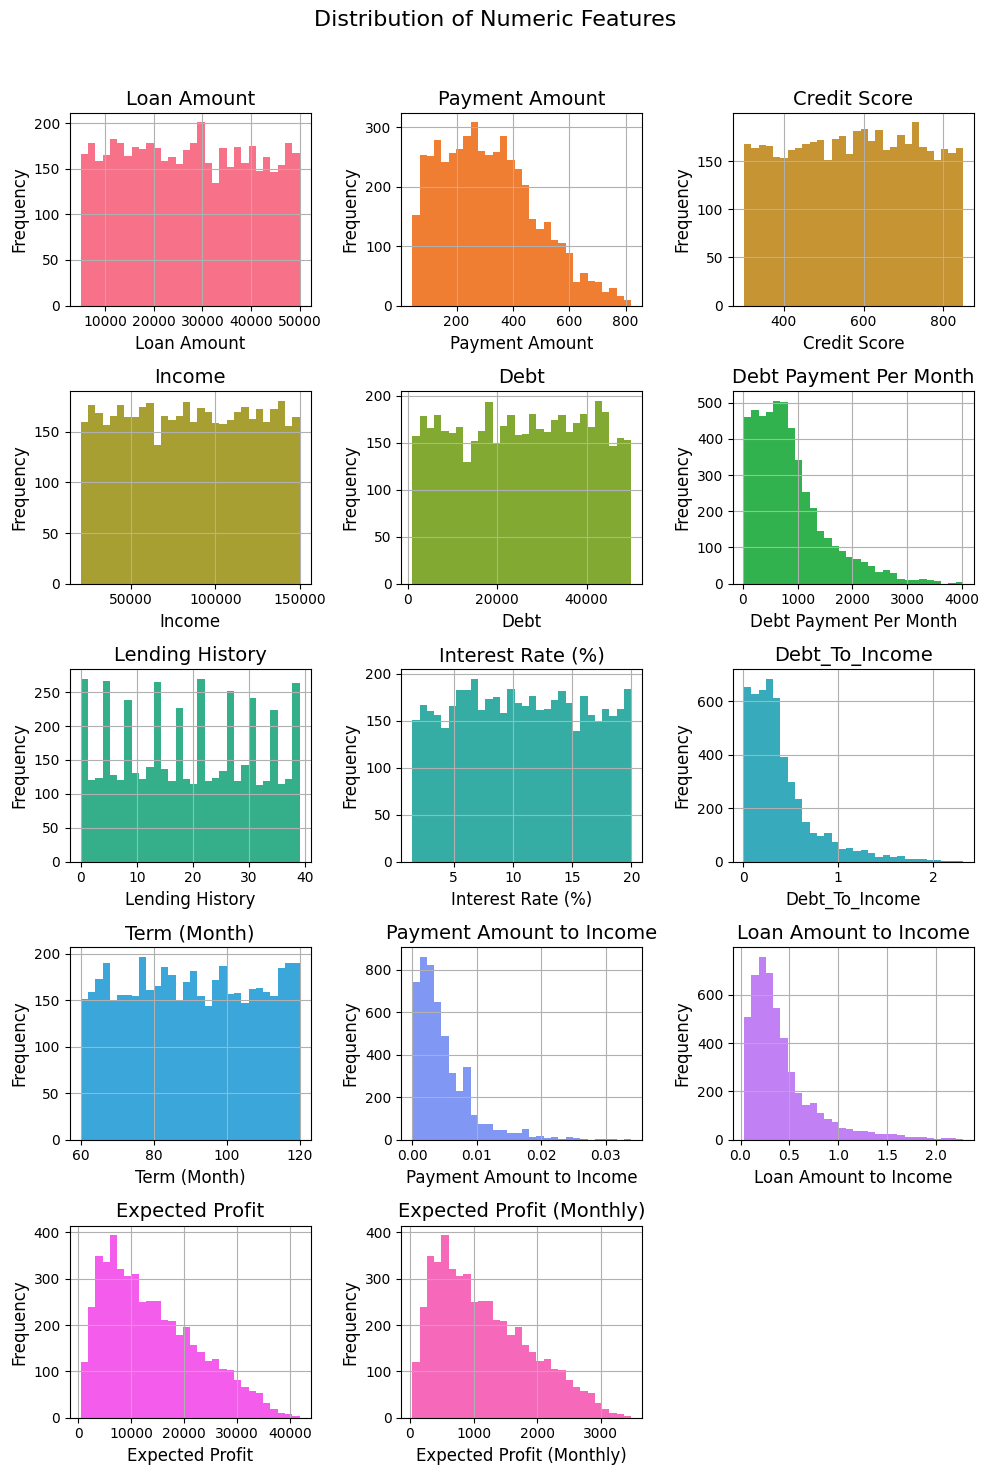

In [13]:
columns = ['Loan Amount', 'Payment Amount', 'Credit Score',
           'Income', 'Debt', 'Debt Payment Per Month', 'Lending History', 'Interest Rate (%)',
           'Debt_To_Income','Term (Month)', 'Payment Amount to Income', 'Loan Amount to Income', 
           'Expected Profit', 'Expected Profit (Monthly)']


colors = sns.color_palette("husl", len(columns))
plt.figure(figsize=(10, 15))
for i, col in enumerate(columns):
    plt.subplot(5,3, i+1)  # Adjust subplot grid as needed
    loan_data[col].hist(bins=30, color=colors[i])
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'{col}', fontsize=14)

plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Checking the distribution of the data's features is crucial. This will give us information on the validity of the data, the spread and variability, and the central tendencies.

Important things to note from the distributions

- I would expect a normal distribution, not uniform for Income
- Most people would have lower Debt Payment and Payment per month, but a few would have higher ones. A right skew distribution makes sense for these two features.
- Why is the distribution of Credit Score uniform? From my understanding, credit score is a huge factor in deciding whether or not a loan is approved. I would assume a left skew for this feature's distribution. Typically people with higher credit scores are more likely to get an approved loan. So this would definitely be under my radar.
- I would assume a normal distribution for Debt, instead of uniform.
- Right skew distirbution for Debt_To_Income, Payment Amount to Income, Loan Amount to Income, and Expected Profit (monthly version too) makes sense.
- Uniform Interest Rate (%) would be weird. I'd assume more people would want to borrow $ if the interest rate is lower.

Because we are seeing more uniform distributions as opposed to normal ones, this means that there is close to equal likelihood in obtaining a certain value in the respected feature. In other words, each value in the range is equally likely to be sampled. That's like saying you're equally likely to randomly pick someone who has a 300 credit score vs someone who has a 650 credit score, which is pretty unrealistic. This is important information to know if we are trying to do unbiased sampling. The uniform distirbutions would alarm me to question the data quality.

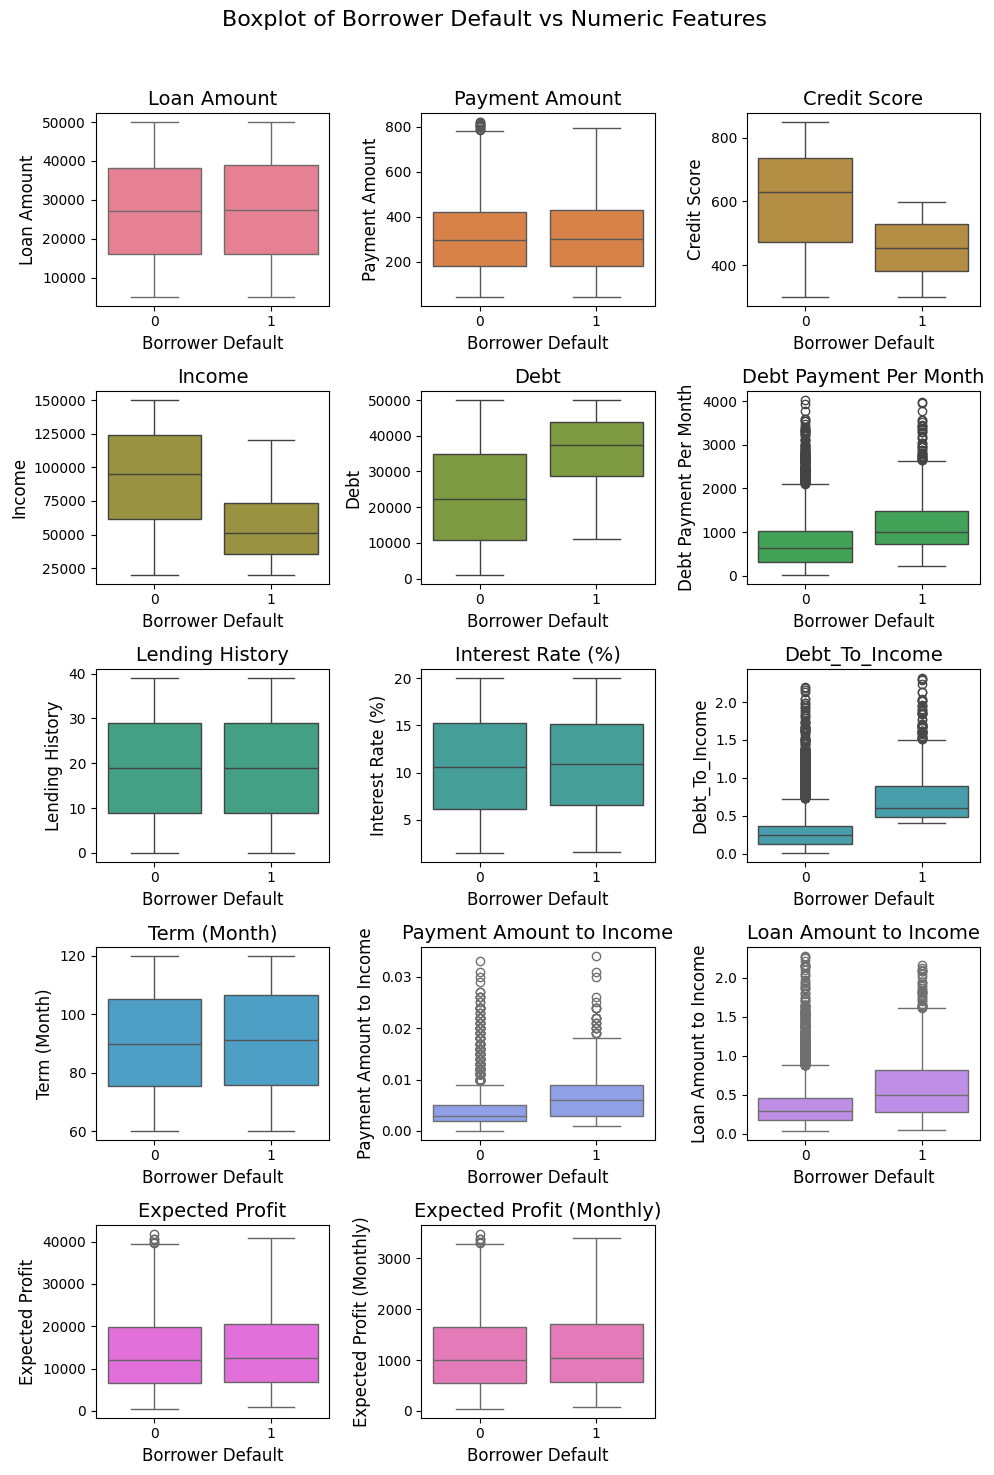

In [14]:
# Define colors for each boxplot
colors = sns.color_palette("husl", len(columns))



plt.figure(figsize=(10, 15))
for i, col in enumerate(columns):
    plt.subplot(5,3, i+1)  # Adjust subplot grid as needed
    sns.boxplot(x='Borrower_default', y=col, data=loan_data, color=colors[i])
    plt.xlabel('Borrower Default', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.title(f'{col}', fontsize=14)

plt.suptitle("Boxplot of Borrower Default vs Numeric Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Important things to note from the boxplots. 
- The defaults are more common with people who have lower incomes.
- The people who default have lower credit scores.
- People with higher payment to income and loan amount to income are more likely to default, but the loan amount and payment amount themselves are around the same for people who default vs not. This is why creating ratio columns is important, because we get more information beyond surface level.
- The duration of the loan term doesn't seem too different for those who default vs not.
- I'm surprised that there are people with over 2.0 debt to income ratio who don't default. But essentially, people who don't default tend to have lower debt-to-income ratio.

There are definitely outliers that I would want to address. Like the people with insanely high debt-to-income ratios. If the data is more realistic, I would actually consider removing the outliers, but for the purpose of this exercise, I won't.

# Modeling

We will not consider gender, age, zip code, and area code to prevent discrimination based on demographics...

In [15]:
# We are NOT using Gender, Zip Code, Area Code, and Age  
features = ['Loan Amount', 'Payment Amount', 'Credit Score', 'Income', 'Debt', 
            "Debt Payment Per Month", "Lending History", 'Debt_To_Income', 'Term (Month)', 
            'Interest Rate (%)', 'Payment Amount to Income', 'Loan Amount to Income', 'Expected Profit', 'Expected Profit (Monthly)']

target = 'Borrower_default'


# splitting the data into X-Y components...
X = loan_data[features]
y = loan_data[target]

#### Scaling data for modelling purposes, but also creating a separate dataset to not scale Expected Profit + Loan Amount for calculation purposes later...

In [16]:
# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add constant term for intercept
X_scaled_with_const = sm.add_constant(X_scaled)

# Convert scaled data back to DataFrame with appropriate column names
columns_with_const = ['const'] + features
X_scaled_df = pd.DataFrame(X_scaled_with_const, columns=columns_with_const)

In [17]:
# Don't scale expected profit, keep as is. We know the feature selection will not include expected profit, 
# but include the unscaled version for risk calculations later.

features = [col for col in X.columns if col not in  ['Expected Profit', 'Loan Amount']]  # Columns to scale
X_excluded = X[['Expected Profit', 'Loan Amount']]  # Column to exclude from scaling

# Separate the columns to scale
X_to_scale = X[features]

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_to_scale)

# Convert scaled data back to DataFrame with appropriate column names
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=X.index)

# Combine the scaled columns with the excluded column
X_combined = pd.concat([X_scaled_df, X_excluded.reset_index(drop=True)], axis=1)

# Add constant term for intercept
X_scaled_with_const = sm.add_constant(X_combined)

# Convert scaled data with constant term back to DataFrame
columns_with_const = ['const'] + features + ['Expected Profit'] + ['Loan Amount']
X_scaled_df_with_const = pd.DataFrame(X_scaled_with_const, columns=columns_with_const, index=X.index)

## Logistic Regression Model 
Define Forward/Backward Stepwise Regression functions (use 0.05 significance)

In [18]:
# Function for forward stepwise regression
def forward_stepwise_regression(X, y, significance_level=0.05):
    initial_features = []
    remaining_features = list(X.columns)
    best_model = None
    while remaining_features:
        p_values = []
        for feature in remaining_features:
            features = initial_features + [feature]
            X_features = X[features]
            model = sm.Logit(y, X_features).fit(disp=0)
            p_values.append(model.pvalues[feature])
        
        min_p_value = min(p_values)
        if min_p_value < significance_level:
            best_feature = remaining_features[p_values.index(min_p_value)]
            initial_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_model = sm.Logit(y, X[initial_features]).fit(disp=0)
        else:
            break
    
    return best_model, initial_features

# Function for backward stepwise regression
def backward_stepwise_regression(X, y, significance_level=0.05):
    initial_features = list(X.columns)
    best_model = sm.Logit(y, X[initial_features]).fit(disp=0)
    
    while len(initial_features) > 1:  # At least one feature is needed (excluding constant)
        p_values = best_model.pvalues
        max_p_value = max(p_values)
        
        if max_p_value > significance_level:
            worst_feature = p_values.idxmax()
            initial_features.remove(worst_feature)
            X_features = X[initial_features]
            best_model = sm.Logit(y, X_features).fit(disp=0)
        else:
            break
    
    return best_model, initial_features

### Compare results, forward and backward features

In [20]:
warnings.filterwarnings("ignore")
# Perform forward stepwise regression
best_model, selected_features = forward_stepwise_regression(X_scaled_df_with_const, y)


# Print the selected features
print("Selected Features from Forward Stepwise Reg:", selected_features)


# Perform backward stepwise regression
best_model_b, selected_features_b = backward_stepwise_regression(X_scaled_df_with_const, y)

# Print the selected features
print("Selected Features from Backward Stepwise Reg:", selected_features_b)

# Print the summary of the best model (doesn't matter if we chooose Forward or Backward, since they're both selecting the same features)
print(best_model.summary())

Selected Features from Forward Stepwise Reg: ['const', 'Debt_To_Income', 'Credit Score', 'Debt', 'Income', 'Loan Amount to Income']
Selected Features from Backward Stepwise Reg: ['const', 'Payment Amount', 'Credit Score', 'Income', 'Debt', 'Debt Payment Per Month', 'Lending History', 'Debt_To_Income', 'Term (Month)', 'Interest Rate (%)', 'Payment Amount to Income', 'Loan Amount to Income', 'Expected Profit (Monthly)', 'Expected Profit', 'Loan Amount']
                           Logit Regression Results                           
Dep. Variable:       Borrower_default   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4994
Method:                           MLE   Df Model:                            5
Date:                Tue, 13 Aug 2024   Pseudo R-squ.:                  0.6732
Time:                        13:42:08   Log-Likelihood:                -798.75
converged:                       True   LL-Null:                      

Both Forward and Backward Stepwise Regression selected the same features: Credit Score, Income, Debt, and Debt_To_Income, and Loan Amount to Income. But because Debt and Income are strongly with Debt_To_Income and Loan Amount to Income, we would need to keep that in mind for multi-collinearity.

#### Based on the Logit Regression Results Summary...
- We can see that the p-values are extremely low for all of the 5 selected features, which means that they are significant beyond the 95% confidence because the p values are less than 0.05.
- The standard errors for all features are low, which indicates that the data points will not deviate much from the model.
- The Pseudo R-squ (a substitute for the R-squared value) is 0.67. This means that roughly 67% of the data is explained by our model that we created.
- The coefficients show that there is a negative relationship between Credit Score and Borrower Default and Loan Amount to Income vs Borrower Default, while holding all variables constant.
- Similarly, the coefficients show that there is a positive relationship between Debt and Borrower Default, but a negative relationship between Debt_to_Income and Borrower_Default while holding all variables constant. It is important to note that the negative relationship occurs for DTI and Borrower_Default due to multi-collinearity, because we're also including income and debt into the model, as selected by our stepwise regression.

In [21]:
# Train/test split and evaluate the best model
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df_with_const, y, test_size=0.3, random_state=12)

In [22]:
expected_profit_test = X_test['Expected Profit'] 
loan_amount_test = X_test['Loan Amount'] 

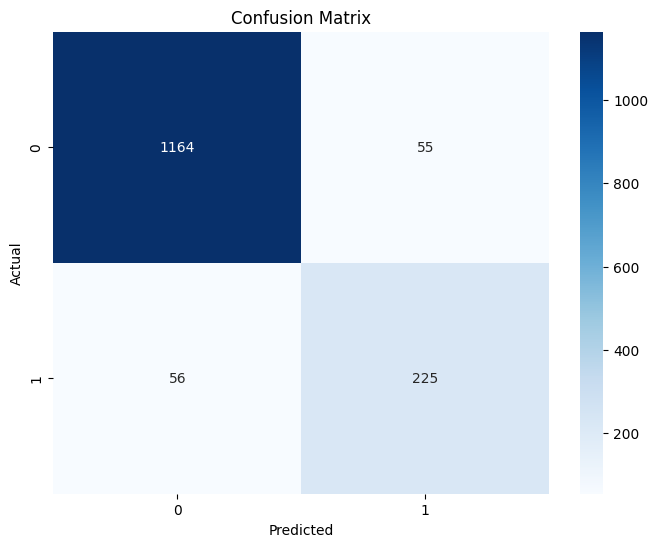

Accuracy: 0.926
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      1219
           1       0.80      0.80      0.80       281

    accuracy                           0.93      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.93      0.93      0.93      1500

Total Profit: $14652774.07


In [23]:
X_test = X_test[selected_features]


X_train_model = X_train[selected_features]
best_model = sm.Logit(y_train, X_train_model).fit(disp=0)

y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)


# heatmap confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# results
print("Accuracy:", accuracy)
print("Classification Report:\n", class_report)


## tryna calculate expected profit based on the model's results, which is why I created those columns earlier
y_test_series = pd.Series(y_test, name='Actual')
y_pred_series = pd.Series(y_pred, name='Predicted')
y_pred_binary = pd.Series(y_pred_binary, name='Predicted_Bin')
expected_profit_test = pd.Series(expected_profit_test, name='Expected_Profit')
loanamount_test = pd.Series(loan_amount_test, name='Loan Amount')

combined_df = pd.concat([X_test.reset_index(drop=True), y_test_series.reset_index(drop=True),
                         y_pred_series.reset_index(drop=True), y_pred_binary.reset_index(drop=True),
                         expected_profit_test.reset_index(drop=True), loanamount_test.reset_index(drop=True)],
                        axis=1)

total_profit = 0

for index, row in combined_df.iterrows():
    if row['Actual'] == 0 and row['Predicted_Bin'] == 1:
        # Skip the profit for this row
        continue
    elif row['Actual'] == 1 and row['Predicted_Bin'] == 0:
        # Subtract Actual * Loan Amount from total profit
        total_profit -= row['Actual'] * row['Loan Amount']
    elif row['Actual'] == 0 and row['Predicted_Bin'] == 0:
        # Add expected profit to total profit
        total_profit += row['Expected_Profit']
# Output the total profit
print(f"Total Profit: ${total_profit:.2f}")

## While subtracting the total loan amount for defaulted borrowers will reduce the profit, this approach might underestimate the actual profit. 
## This is because we assume that borrowers made some payments before defaulting. 
## Unfortunately, we lack date information on when the loan was defaulted to verify this.

Formulas for reference.

Accuracy = (TP + TN)/(TP + TN + FP + FN)
Precision = TP /(TP + FP)
Recall = TP/(TP + FN)
F-1 = 2(Precision * Recall) / (Precision + Recall)

#### From these results... (I will explain it fully here, but tldr for the other models) 
- The accuracy is .926, meaning that 92.6% of the 1500 borrowers were classified correctly.
- The precision tells us that 95% of the borrowers who are classified as non-defaults were actually non-defaults! But 80% of the borrowers who defaulted are truly defaults.
- The F1-score of .95 for the Non-defaults tells us that there is a strong balance between precision and recall. However, the f1-score of .80 for the defaults indicates a fairly good balance, but not super strong.
- The support tells us the actual occurance of non-defaults (1219) vs defaults (281)

Macro Average... 
- Precision: 0.88 - The unweighted mean precision across both classes.
- Recall: 0.88 - The unweighted mean recall across both classes.
- F1-score: 0.88 - The unweighted mean F1-score across both classes.

Weighted Average...
- Precision: 0.93 - The mean precision weighted by the number of instances in each class.
- Recall: 0.93 - The mean recall weighted by the number of instances in each class.
- F1-score: 0.93 - The mean F1-score weighted by the number of instances in each class.

Takeaways...
- The model performs very well on the majority class (non-default), with high precision, recall, and F1-score.
- The model performs reasonably well on the minority class (default), but not as well as on the majority class. The precision and recall are slightly lower, which is common when dealing with imbalanced datasets.
- Overall, the model has a high accuracy of 92.7%, indicating it makes correct predictions most of the time.
- The macro average scores indicate that, when treating each class equally, the model is performing well.
- The weighted average scores are high, reflecting the model's strong performance, particularly influenced by the majority class due to its higher number of instances.
- The lower precision and recall for the default class suggest that the model might be slightly biased towards predicting the majority class (non-default).
- **We would have gained $14,652,774.07 with this model**

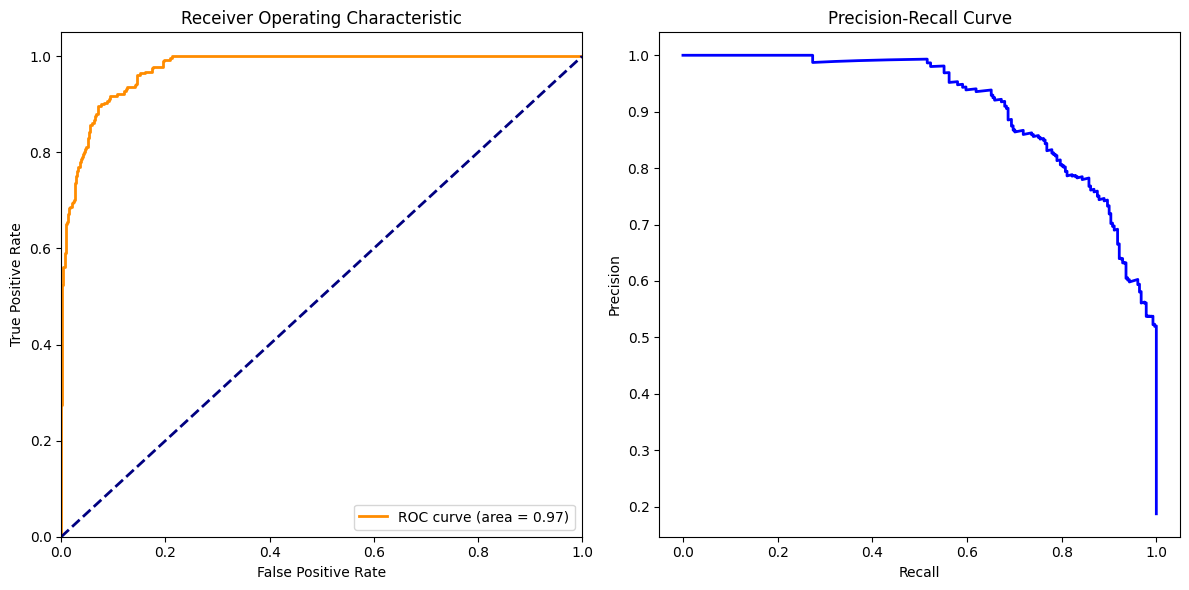

In [24]:
y_pred_prob = y_pred 
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc='lower right')

# PRC
ax2.plot(recall, precision, color='blue', lw=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')


plt.tight_layout()
plt.show()

#### Based on the ROC and PRC graph... 
- The Logistic Regression model has 97% accuracy.
- The AUC of .97 tells us that the model is strong, meaning that the model has the strong ability to differentiate between positive and negative classes (Default vs Not).
- The Precision Recall curve tells us that the model has decent precision and recall. If it was perfect, the lines would form a right angle.

This tells us that Logistic Regression is a decent model!

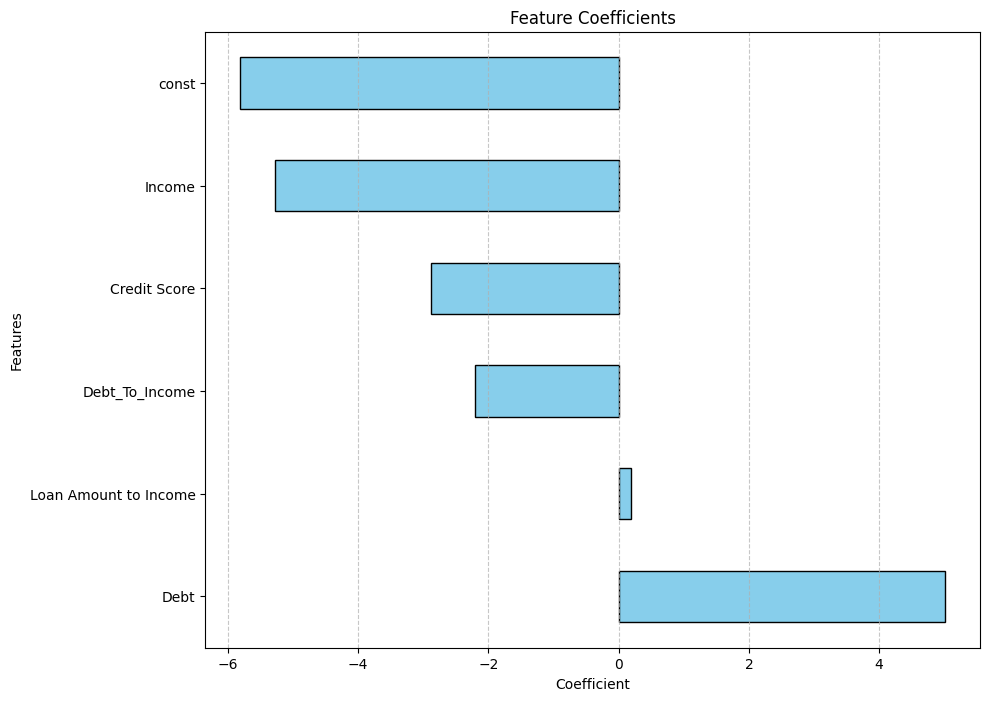

In [25]:
coefficients = pd.Series(best_model.params, index=X_train_model.columns)
coefficients = coefficients.sort_values(ascending=False)


plt.figure(figsize=(10, 8))
coefficients.plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Feature Coefficients')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Based on the feature selection graph... 
- Debt, Loan Amount to Income, DTI, Credit Score, and Income are relevant to the model
- Debt_To_Income (-2.0557): A negative coefficient indicates that higher Debt to Income ratios are associated with lower odds of defaulting, holding all constant.
- Credit Score (-2.9178): A negative coefficient indicates that higher credit scores are associated with lower odds of defaulting, holding all constant.
- Debt (4.8335): A positive coefficient indicates that higher debt amounts are associated with higher odds of defaulting, holding all constant.
- Income (-5.1282): A negative coefficient indicates that higher income is associated with lower odds of defaulting, holding all constant.
- Loan Amount to Income (0.1653): A positive coefficient indicates that a higher loan amount relative to income is associated with higher odds of defaulting, holding all constant.

It is upmost important to understand that our features have some correlation with each other, which is why some of the features have a surprising relationship with borrower_default. Normally, higher DTI is associated with higher odds of defaulting, but because we also included variables like Income and Debt into our models, DTI is made redundant. However, the stepwise regression is optimized to select the features that would significantly influence the model.

## Support Vector Machines

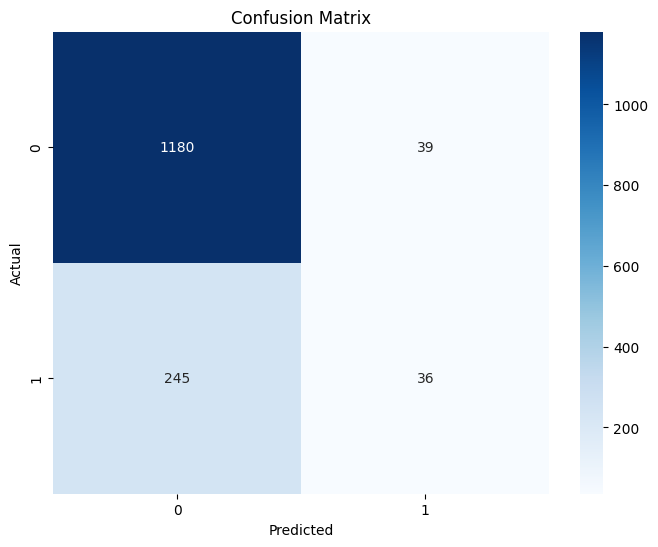

Accuracy: 0.8106666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89      1219
           1       0.48      0.13      0.20       281

    accuracy                           0.81      1500
   macro avg       0.65      0.55      0.55      1500
weighted avg       0.76      0.81      0.76      1500

Total Profit: $9916267.04


In [27]:
## these were standardized from before...
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=12)


pca = PCA(n_components=2)  # Set to 2 for 2D visualization

# Support Vector Machine model
svc = SVC(kernel='linear', random_state=42)

# Create a pipeline with PCA and SVM
pipeline = Pipeline([
    ('pca', pca),
    ('svm', svc)
])


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print results
print("Accuracy:", accuracy)
print("Classification Report:\n", class_report)

y_test_series = pd.Series(y_test, name='Actual')
y_pred_series = pd.Series(y_pred, name='Predicted')
expected_profit_test = pd.Series(expected_profit_test, name='Expected_Profit')
loanamount_test = pd.Series(loan_amount_test, name='Loan Amount')

combined_df = pd.concat([X_test.reset_index(drop=True), y_test_series.reset_index(drop=True),
                         y_pred_series.reset_index(drop=True),expected_profit_test.reset_index(drop=True),
                         loanamount_test.reset_index(drop=True)], axis=1)
total_profit = 0

for index, row in combined_df.iterrows():
    if row['Actual'] == 0 and row['Predicted'] == 1:
        # Skip the profit for this row
        continue
    elif row['Actual'] == 1 and row['Predicted'] == 0:
        # Subtract Actual * Loan Amount from total profit
        total_profit -= row['Actual'] * row['Loan Amount']
    elif row['Actual'] == 0 and row['Predicted'] == 0:
        # Add Expected to total profit
        total_profit += row['Expected_Profit']
# Output the total profit
print(f"Total Profit: ${total_profit:.2f}")

#### From these results... 
- The accuracy is 0.81, meaning that 81% of the 1500 borrowers were classified correctly.
- TThe precision tells us that 83% of the borrowers who are classified as non-defaults were right. But 48% of the borrowers who defaulted are truly defaults. The precision for the defaulters is low.
- The recall score and f1-score are extremely low for the defaulters, this indicates that the model is weak at predicting defaulters, but pretty robust at predicting non-defaulters.

Takeaways...
- The model performs well in identifying borrowers who don't default, but struggles signficantly with those who default. The accuracy can be misleading due to the class imbalance between defaulters and non defaulters.
- **We would have gained $9,916,267.04 with this model**

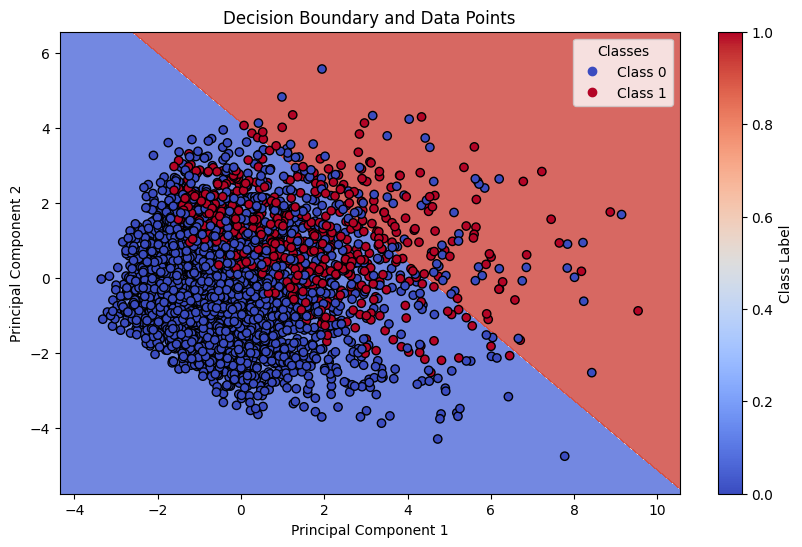

In [28]:
pca_model = pipeline.named_steps['pca']
svm_model = pipeline.named_steps['svm']


def plot_decision_boundaries(X, y, model, pca):
    # Apply PCA transformation to the data
    X_transformed = pca.transform(X)

    
    x_min, x_max = X_transformed[:, 0].min() - 1, X_transformed[:, 0].max() + 1
    y_min, y_max = X_transformed[:, 1].min() - 1, X_transformed[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    

    mesh_grid = np.c_[xx.ravel(), yy.ravel()]

    
    Z = model.predict(mesh_grid)
    Z = Z.reshape(xx.shape)
    

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    

    scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
    
 
    cbar = plt.colorbar(scatter)
    cbar.set_label('Class Label')
    
    # Add labels and title
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Decision Boundary and Data Points')
    
    # Add legend
    handles, labels = scatter.legend_elements()
    plt.legend(handles, [f'Class {label}' for label in np.unique(y)], title="Classes")
    
    plt.show()

# Plot the decision boundaries using the training data
plot_decision_boundaries(X_train, y_train, svm_model, pca_model)

#### Based on the graph...
Here is the SVM that incorporates PCA (feature dimension reduction). As seen here, the red points are those who default while the blue points are the non-defaulters. The SVM incorporates a division line where everything in the blue shade are predicted to be non-defaulters and vise versa for the red shade. We can see how fairly the model struggles to predict those who default, but is relatively accurate for predicting those who don't default.

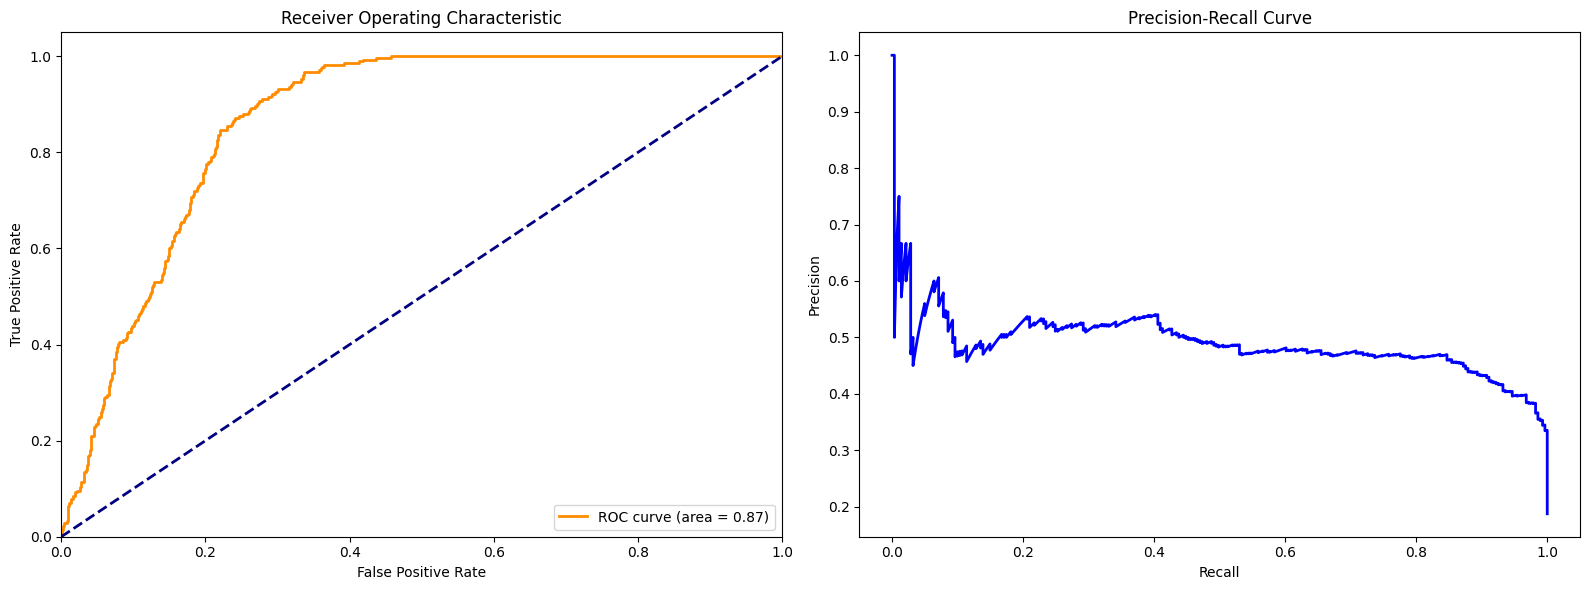

In [29]:
y_pred_prob = pipeline.decision_function(X_test)  

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc='lower right')

# Precision-Recall Curve
ax2.plot(recall, precision, color='blue', lw=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')

# Adjust layout
plt.tight_layout()
plt.show()

#### Based on the ROC and PRC graph...
- The AUC of .87 indicates that the model has some discriminatory power. Not as strong as the Logistic Model's ROC graph.
- The Precision Recall has a poor tradeoff between precision and recall. The high recall and low precision indicates that the model identifies a lot of true positives but also includes many false positives.
I'd avoid using SVM...

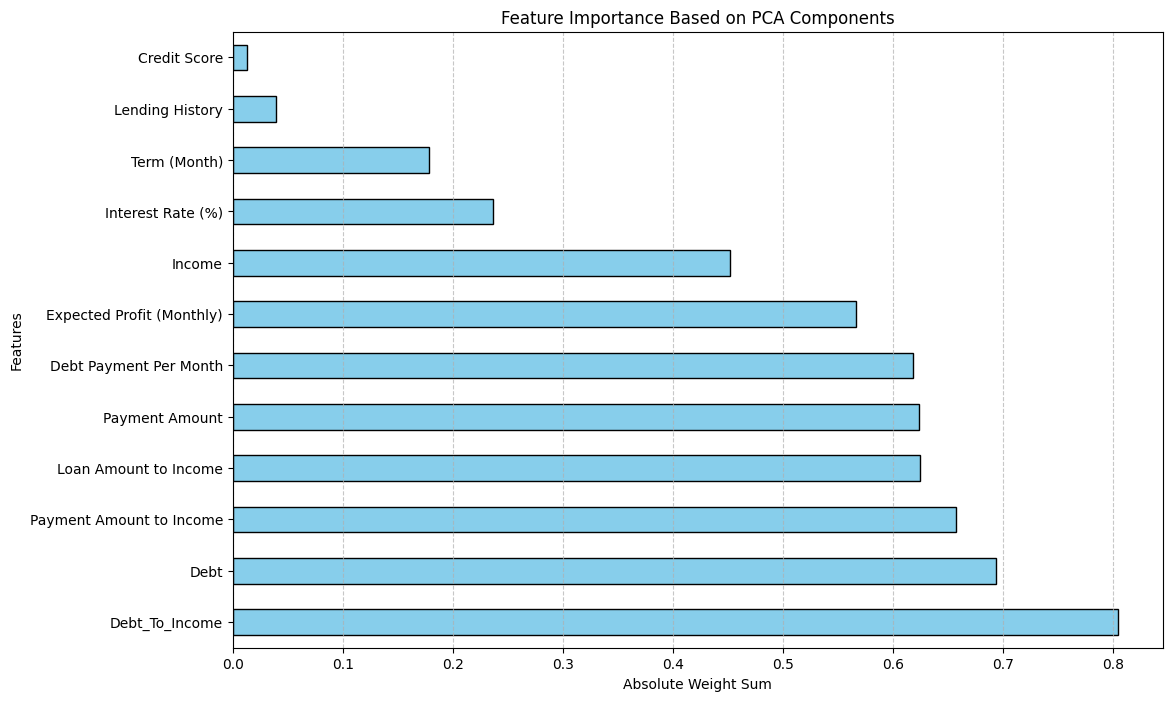

In [30]:
pipeline.fit(X_train, y_train)
pca_components = pipeline.named_steps['pca'].components_


feature_names = X_train.columns


pca_weights = pd.DataFrame(pca_components.T, index=feature_names, columns=[f'PC{i+1}' for i in range(pca_components.shape[0])])


abs_weights = pca_weights.abs().sum(axis=1)
abs_weights = abs_weights.sort_values(ascending=False)


plt.figure(figsize=(12, 8))
abs_weights.plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel('Absolute Weight Sum')
plt.ylabel('Features')
plt.title('Feature Importance Based on PCA Components')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### It is important to note that... 
- PCA reduced the number of dimensions of the data by finding the most important patterns.
- The features on the bottom are the most important, according to PCA.
- However, based on the correlation matrix that was created earlier, it would be outrageous to give the least weight to credit score, as credit score proves to have a strong correlation to borrower defaults, according to the correlation matrix.

## Decision Tree Classifier
Scaling is unnecessary for tree-related models

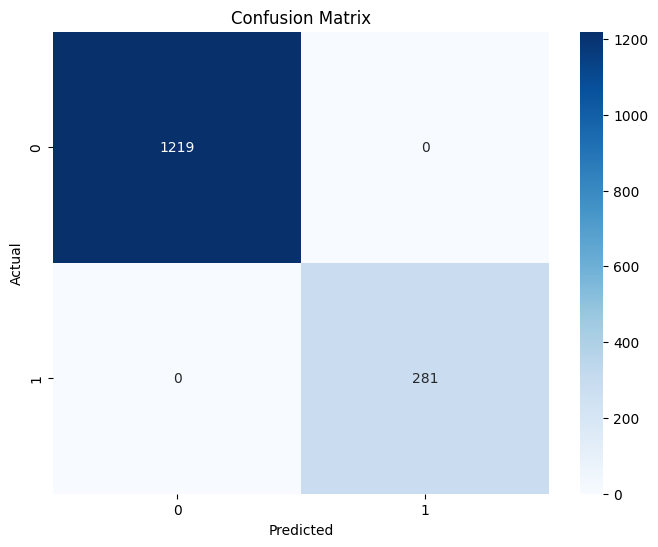

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1219
           1       1.00      1.00      1.00       281

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

Total Profit: $16950645.08


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)


model = DecisionTreeClassifier(random_state=12)


model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)



plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



print("Accuracy:", accuracy)
print("Classification Report:\n", class_report)

y_pred_series = pd.Series(y_pred, name='Predicted')
expected_profit_test = pd.Series(expected_profit_test, name='Expected_Profit')
combined_df = pd.concat([y_pred_series.reset_index(drop=True),expected_profit_test.reset_index(drop=True)], axis=1)
print(f"Total Profit: ${combined_df [combined_df ['Predicted'] == 0]['Expected_Profit'].sum():.2f}")

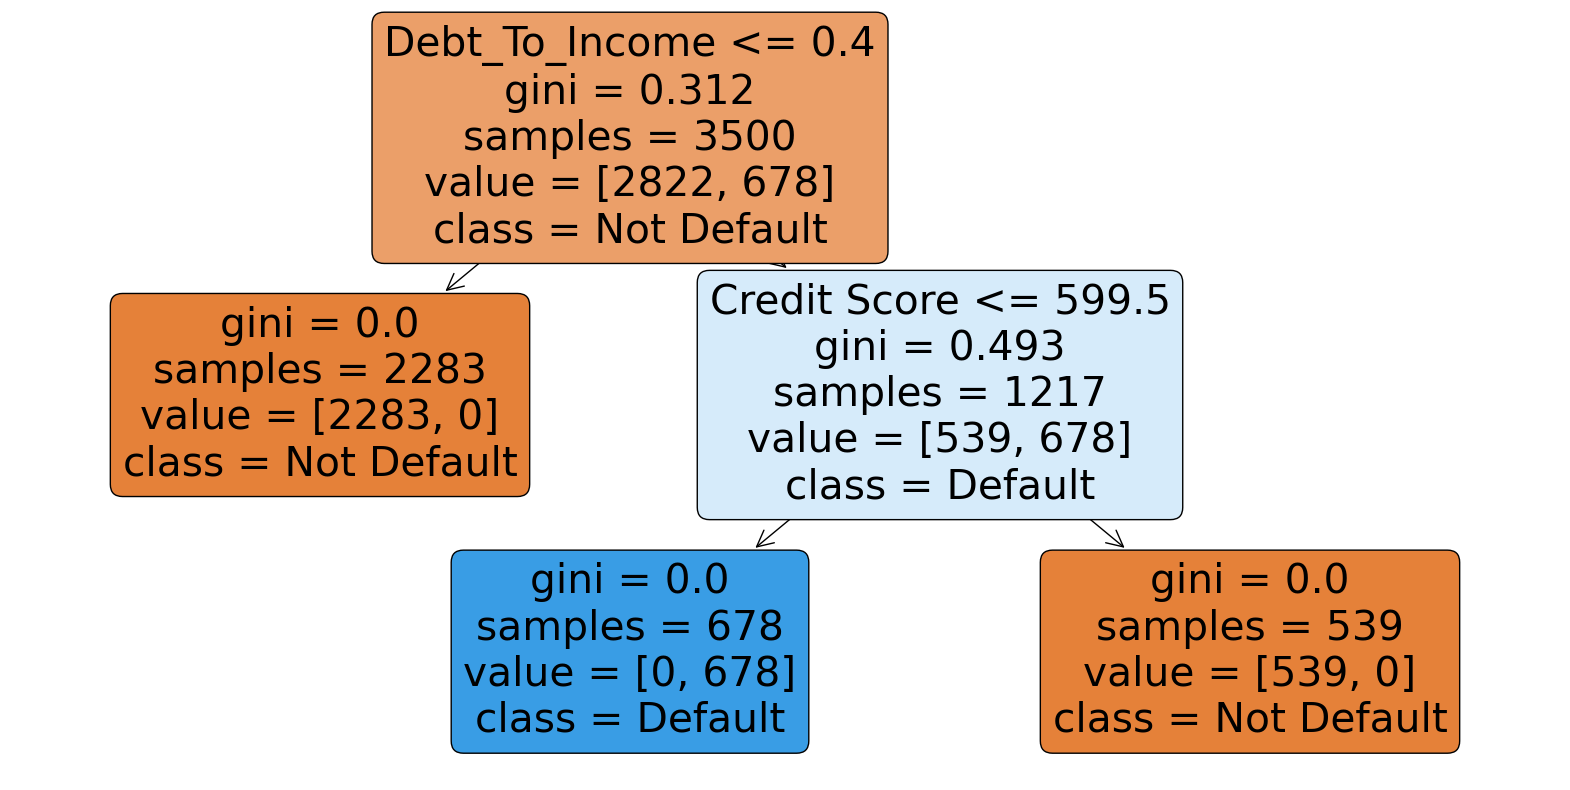

In [32]:
# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(model, 
          feature_names=X_train.columns,  
          class_names=['Not Default', 'Default'],  
          filled=True, 
          rounded=True)
plt.show()

<Figure size 1000x800 with 0 Axes>

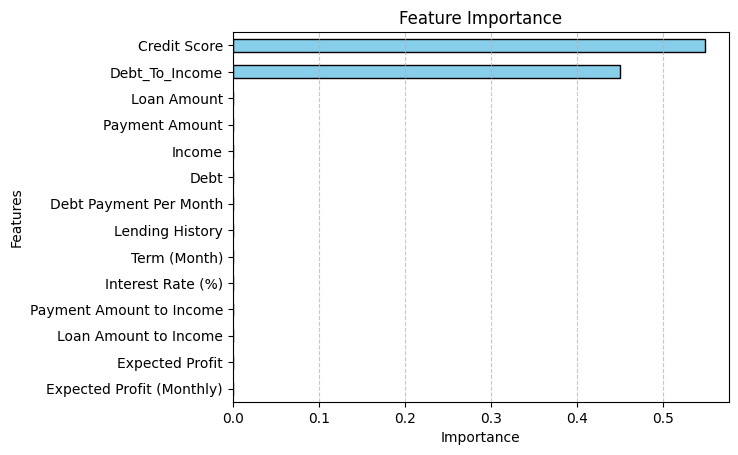

In [33]:
feature_importance = model.feature_importances_
features = X.columns


importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 8))
importance_df.plot(kind='barh', x='Feature', y='Importance', color='skyblue', edgecolor='black', legend=False)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

#### From these results... 
- The Decision Tree model has 100% accuracy.
- If the DTI is less than 0.4, the borrowers will automatically be classified as non-defaulters.
- If the borrower's credit score is above 599.5 and has a higher than 0.4 DTI, he/she will not be classified as defaulter.
- If the borrower's credit score is less than or equal to 599.5 and has a DTI that is higher than 0.4, then he/she will be classified as a defaulter.

Takeaways...

- It is clear that credit score and DTI are the most important features for this model (credit score takes the cake).
- **We would have gained $16,950,645.08 with this model, which is the max that we could have gained**

Gini is the measure of how mixed or "impure a dataset is". If it's close to 0, this means everyone has similar value. If the gini index is close to 1, then there is a huge difference between the lower and higher values. The gini score of 0.312 (DTI node) and 0.493 (Credit Score node) indicate that there is more inequality between those features. So with a gini score of 0.312 and 0.493, our model has the ability to differentiate between the classes (defaulters vs non-defaulters), but perfection should not be expected.

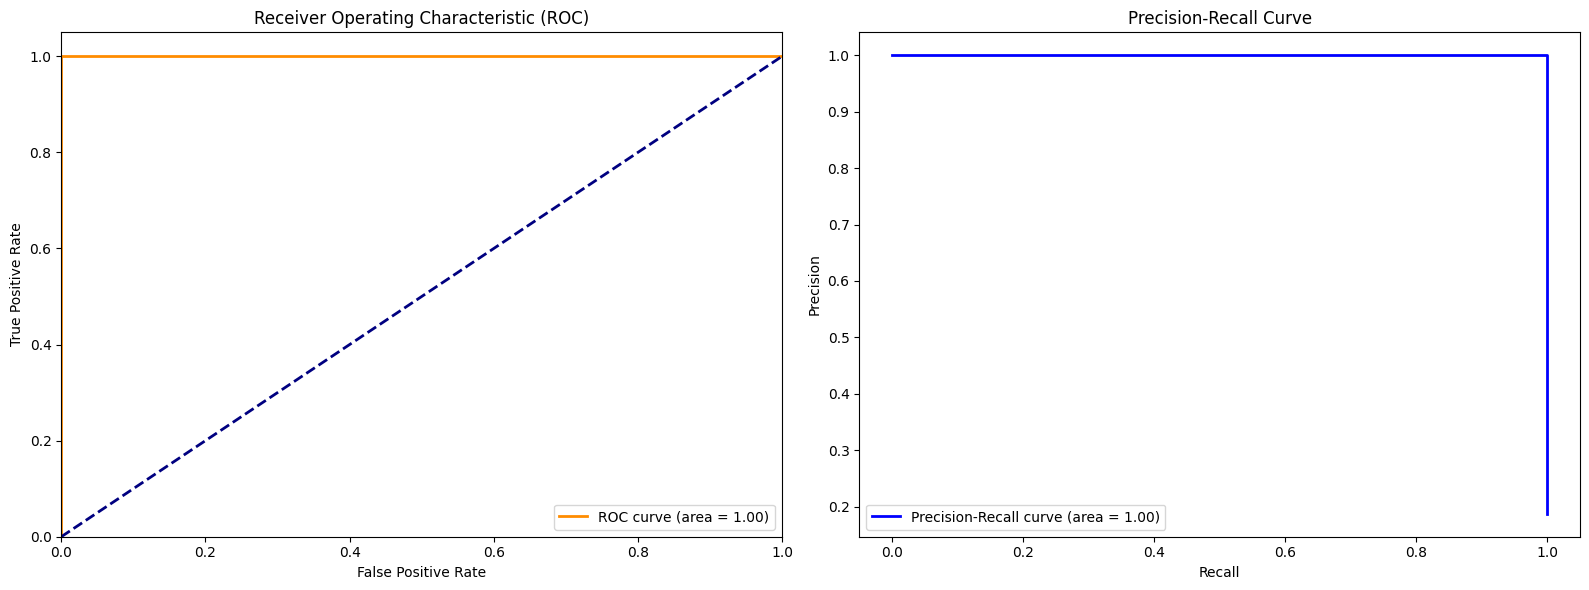

In [34]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(loc='lower right')

# Precision-Recall Curve
ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc='lower left')

# Adjust layout
plt.tight_layout()
plt.show()

#### From these results...
- The Decision Tree model has 100% accuracy.
- The AUC of 1 tells us that the model is perfect, meaning that the model has the strong ability to differentiate between positive and negative classes.
- The PR AUC of 1 tells us that the model has perfect precision and recall.

Takeaways...

- This may be a good model, because we don't use too many features (only 2) and it does an extremely good job. Less features = less prone to noise.

## XGBoosting
Scaling is unnecessary for tree-related models

Accuracy: 1.0000
Confusion Matrix:
[[1219    0]
 [   0  281]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1219
           1       1.00      1.00      1.00       281

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



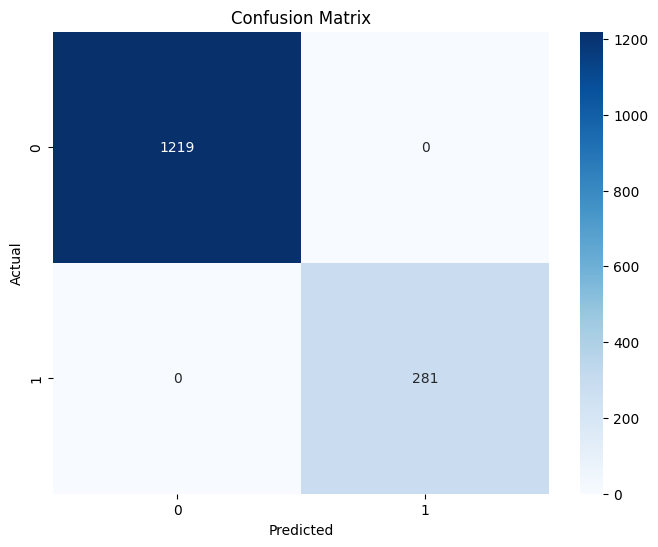

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)


xgb_model = xgb.XGBClassifier(eval_metric='logloss')


xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC and Precision-Recall curves


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

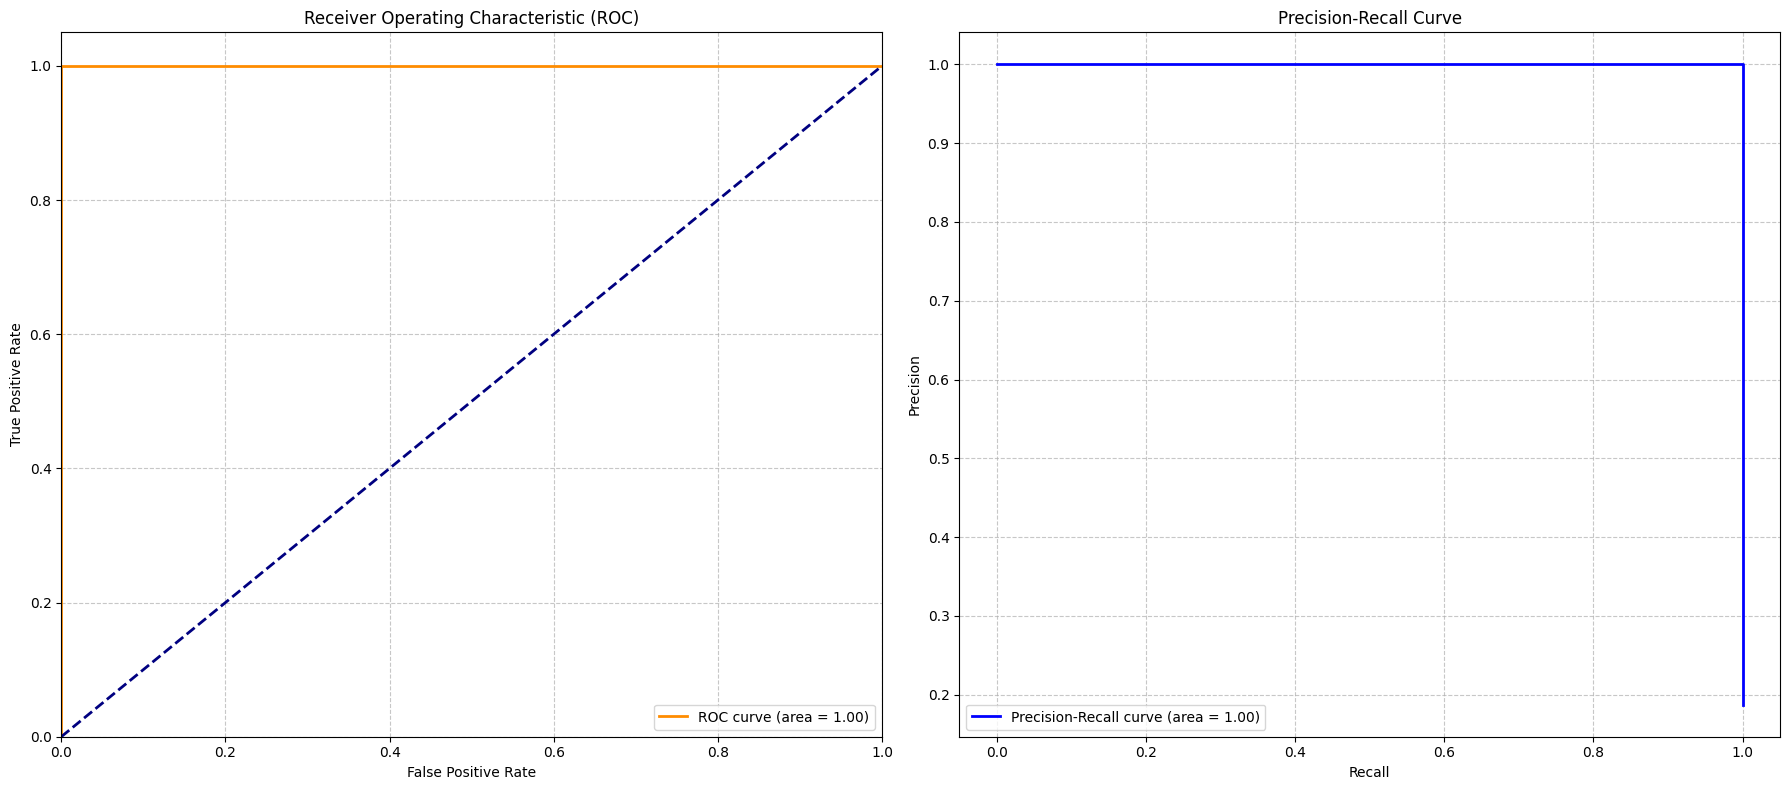

In [36]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))


ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(loc='lower right')
ax1.grid(True, linestyle='--', alpha=0.7)


ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc='lower left')
ax2.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

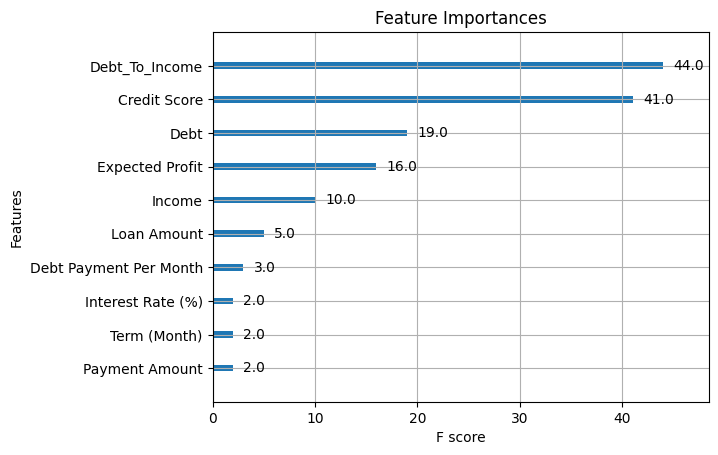

In [37]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, title='Feature Importances')
plt.show()

#### From these results... 
- The xgboost model has 100% accuracy.
- The AUC of 1 tells us that the model is perfect, meaning that the model has the strong ability to differentiate between positive and negative classes.
- The PR AUC of 1 tells us that the model has perfect precision and recall.

Takeaways...
- This may be a sign of overfitting, especially since more features are considered in this model, as opposed to the Decision Tree.
- **We would have gained $16,950,645.08 with this model, similar to the Decision tree, since both are 100% accurate**

If we prioritize achieving the highest total profit, the Decision Tree and XGBoost models are the top performers. However, for simplicity, the Decision Tree Classifier is the preferable option. It uses only 2 features (Credit Score and DTI), which is easier to manage compared to the 10 features used by the XGBoost model. While XGBoost refines its predictions through a sequence of models that learn from past errors and ultimately combines them into a single final model, the Decision Tree offers a more straightforward approach.

Although decision trees are typically prone to overfitting due to how the model will build a series of branches/leaves, this particular model that we have only contains 2 features and the depth of the tree is very short (good). Fewer features mean less prone to noise.

One might argue that logistic regression could be a better choice than XGBoost. Despite XGBoost achieving perfect accuracy in our experiment, it is highly susceptible to overfitting if not properly tuned. XGBoost’s method of correcting errors from previous trees makes it more sensitive to noise, whereas logistic regression is less affected by this issue. Additionally, with logistic regression using only 5 features compared to XGBoost's 10, the logistic regression model is simpler and less likely to be influenced by noise. However, the XGBoost model is expected to generate 16,950,645.08, while the logistic regression model is projected to generate 14,652,774.07, making XGBoost potentially 15% more profitable.

The SVM model might be less prone to noise compared to most of the other models we used in this exercise, due to the non-complex nature of its classifier. Additionally, with the usage of PCA, the data dimensions are reduced without losing much information, so that noise would be reduced. However, when considering the expected total profit, it doesn't make sense to keep the SVM model. The Decision Tree model is expected to generate approximately 16,950,645.08, which is about 170% of the 9,916,267.04 that the SVM model would bring in, and the Decision Tree model is also not too prone to noise, considering that there are only 2 features considered in that model.

Depending on the goal, if we want to include more factors towards determining whether or not someone will default, best to use XGBoost, otherwise, **Decision Tree wins!**